# Cross-Sell Insurance

# 0.0. IMPORTS

In [1]:
import os
import numpy                   as np
import pandas                  as pd
import pickle
import seaborn                 as sns
import psycopg2                as pg
import scikitplot              as skplt
import credentials.credentials as c


from sklearn                   import ensemble, neighbors
from sklearn.tree              import DecisionTreeClassifier
from matplotlib                import pyplot as plt
from sklearn.linear_model      import LogisticRegression
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection   import train_test_split

path = os.getcwd().replace('\\', '/')

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
# # Criando a conexão e salvando arquivo

# conn = pg.connect( user=c.username, 
#                    password=c.password,
#                    host=c.host,
#                    port=c.port,
#                    database=c.database)
# query =  """
#     SELECT *
#     FROM pa004.users u LEFT JOIN pa004.vehicle   v ON u.id=v.id
#                        LEFT JOIN pa004.insurance i ON u.id=i.id
# """
# df_raw = pd.read_sql(query, conn)
# df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
# path = os.getcwd().replace('\\', '/') + '/data/train.csv'
# df_raw.to_csv(path, index=False)

df_raw = pd.read_csv('data/train.csv')

# 1.0. DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

In [4]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.1. Dimensão dos dados

In [5]:
df1.shape
print("Número de Linhas: {}".format(df1.shape[0]))
print("Número de Colunas: {}".format(df1.shape[1]))

Número de Linhas: 381109
Número de Colunas: 12


## 1.2. Tipo de Dados

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Valores Ausentes

In [7]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Alterando Tipo de Dados

In [8]:
df1.region_code = df1.region_code.astype( "int64")
df1.annual_premium = df1.annual_premium.astype( "int64")
df1.policy_sales_channel = df1.policy_sales_channel.astype( "int64")

In [9]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

## 1.5. Estatística Descritiva


In [10]:
num_att = df1.select_dtypes( include=['int64'])
cat_att = df1.select_dtypes( exclude=['int64'])

### 1.5.1. Atributos Numericos 


In [11]:
# Medidas de tendencia central
ct1 = pd.DataFrame( num_att.apply(np.mean) ).T
ct2 = pd.DataFrame( num_att.apply(np.median) ).T

# Medidas de Dispersão - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_att.apply(np.std) ).T
d2 = pd.DataFrame( num_att.apply(min) ).T
d3 = pd.DataFrame( num_att.apply(max) ).T
d4 = pd.DataFrame( num_att.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply( lambda x: x.kurtosis() ) ).T
                  
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ["Atributos", 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,Atributos,min,max,range,media,mediana,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. ENGENHARIA DE FEATURES

In [12]:
df2 = df1.copy()
cat_att.apply( lambda x: x.unique() )

gender                             [Male, Female]
vehicle_age       [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                          [Yes, No]
dtype: object

In [13]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( 
    lambda x: 'over_2_years' if x == '> 2 Years' else 'below_1_year' 
                             if x == '< 1 Year' else 'between_1_2_years' )

# vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. FILTRAGEM DOS DADOS

In [14]:
df3 = df2.copy()

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [15]:
df4 = df3.copy()

## 4.1. Análise Univariada

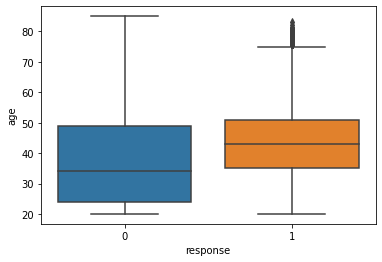

In [16]:
# Age
sns.boxplot(x='response', y='age',data=df4);

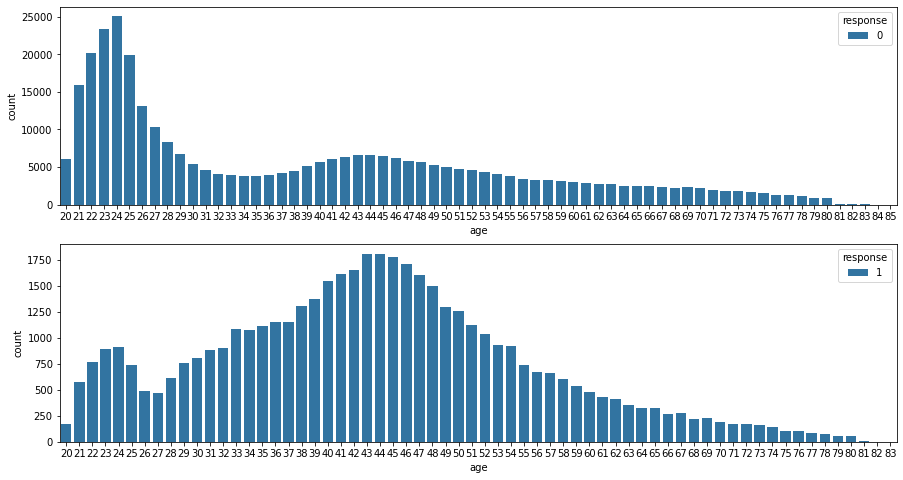

In [55]:
# aux00 =  df4.loc[ df4['response'] == 0, 'age']
# sns.histplot( aux00 );


fig, axs = plt.subplots( nrows=2, figsize=(15,8) )
sns.countplot(x='age', data = df4[ df4['response'] == 0], hue='response', ax=axs[0])
sns.countplot(x='age', data = df4[ df4['response'] == 1], hue='response', ax=axs[1]);

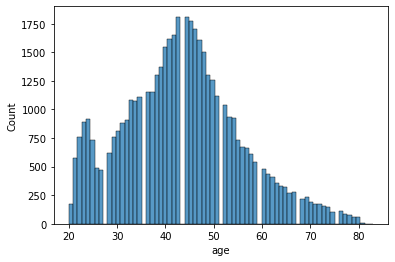

In [18]:
aux00 =  df4.loc[ df4['response'] == 1, 'age']
sns.histplot( aux00 );

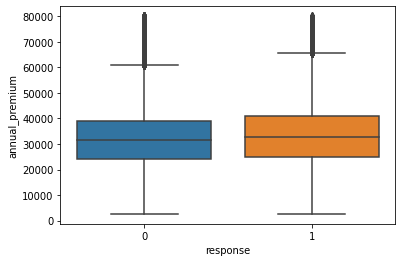

In [19]:
# Annual premium
aux00 = df4.loc[ df4['annual_premium'] < 80000]
sns.boxplot(x='response', y="annual_premium", data=aux00);

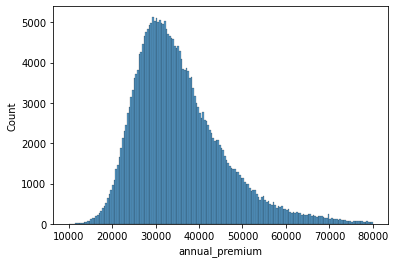

In [20]:
aux = df4.loc[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

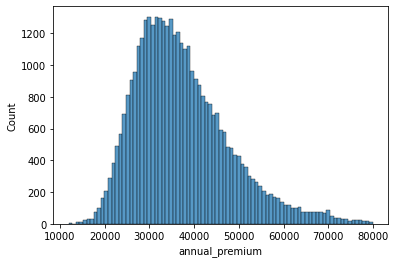

In [21]:
aux = df4.loc[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

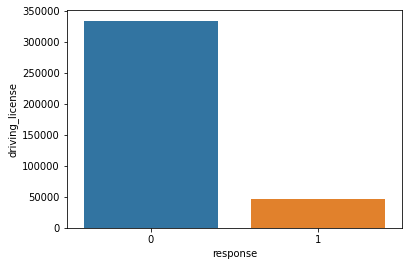

In [22]:
# driving license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux.head()

aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot(x='response', y='driving_license', data=aux);

# eu tenho muito mais pessoas que não dirigem e tmb não estão interessadas em adquirir o seguro

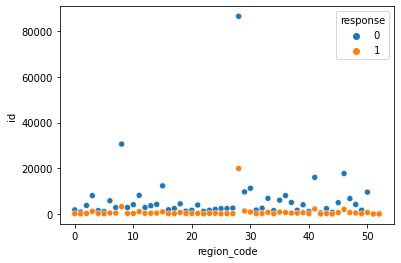

In [23]:
# Region Code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

In [24]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
# vehicle_age
# df4[['id', 'vehicle_age', 'response']].groupby(['vehicle_age', 'response']).count().reset_index()
df4[['vehicle_age', 'response']].value_counts( normalize=True).reset_index().sort_values('vehicle_age')

,vehicle_age,response,0
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


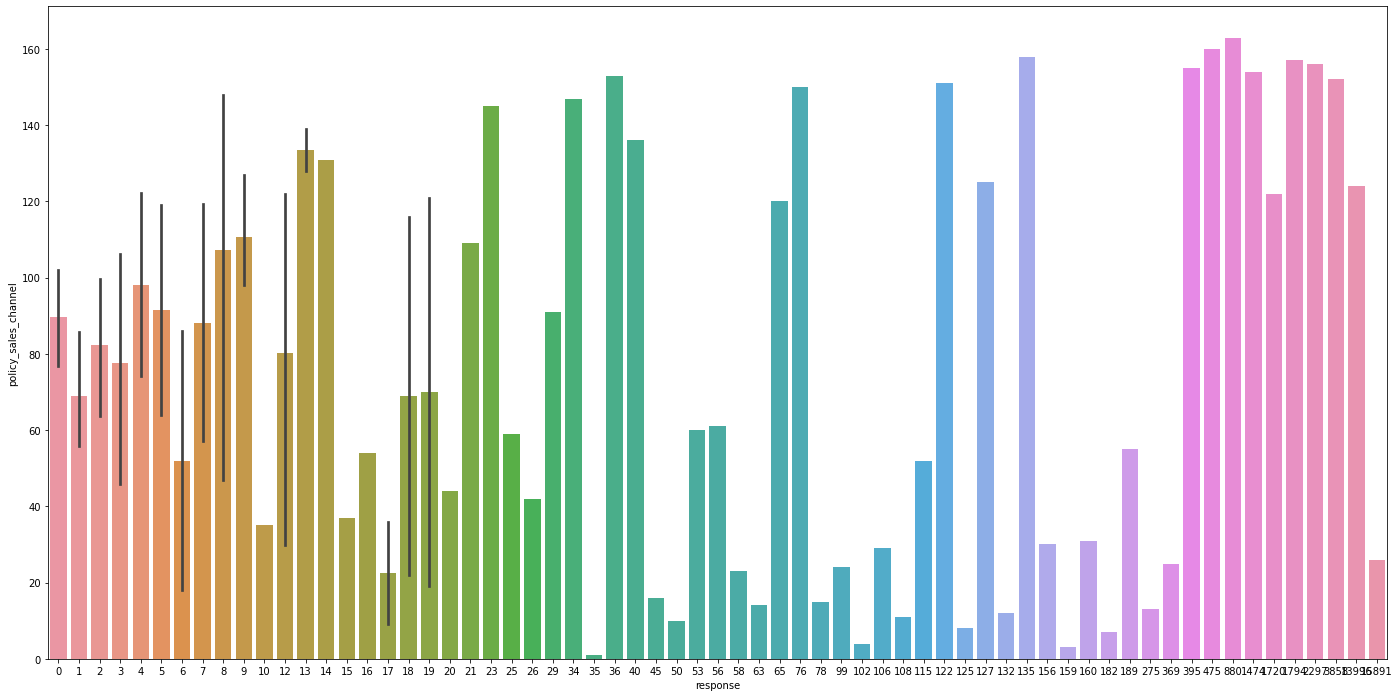

In [26]:
# policy_sales_channel
plt.figure( figsize=(24,12))
aux =  df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux);

<AxesSubplot:xlabel='response', ylabel='vintage'>

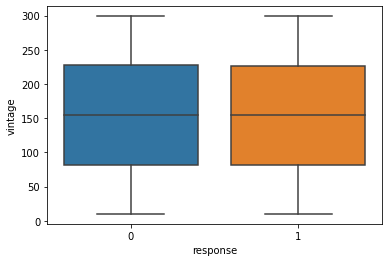

In [27]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

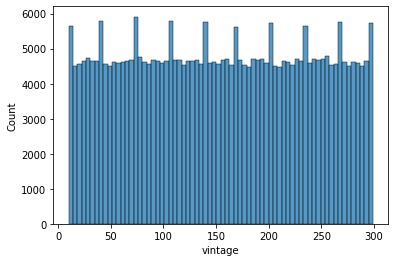

In [28]:
aux =  df4.loc[ df4.response == 0, 'vintage']

sns.histplot( aux )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

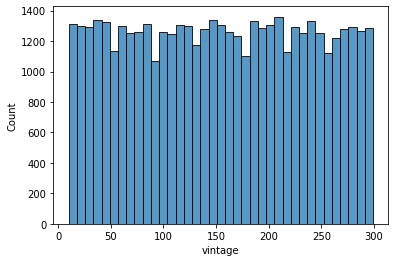

In [29]:
aux =  df4.loc[ df4.response == 1, 'vintage']

sns.histplot( aux )

# 5.0. PREPARAÇÃO DOS DADOS

In [30]:
df5 = df4.copy()

In [31]:
X = df5.drop('response', axis=1)
y = df5.response.copy()

x_train, x_validation, y_train, y_validation = train_test_split( X, y, test_size=0.2)

df5 = pd.concat( [x_train, y_train], axis=1)

## 5.1. Standardization

In [32]:
ss = StandardScaler()

# annual_premium -> bem parecido com uma normal
df5['annual_premium']  = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( path +'/src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [33]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()


# age -> Não é muito próxima de uma normal 
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( path +'/src/features/mms_age_scaler.pkl', 'wb' ) )

# vintage -> Só vou reescalar, não aparenta ser útil
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( path +'/src/features/mms_vintage_scaler.pkl', 'wb' ) )

## 5.3. Encoder

In [34]:
# gender -  One Hot Encoding /  Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( path +'/src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Frequency Encoding, ou Target Encoding, ou Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( path +'/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / ORDER ENCODING / Frequence Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() /  len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( path +'/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Preparação dos dados de Validação

In [35]:
# gender 
x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform( x_validation[['age']].values )

# region_code
x_validation.loc[ :, 'region_code'] = x_validation['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / ORDER ENCODING / Frequence Encoding
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values)

# policy_sales_channel - Frequency Encoding
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. SELEÇÃO DE ATRIBUTOS

## 6.2. Importancia das Features

In [36]:
# Definição do Modelo
forest = ensemble.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# Data Preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.271869
0                 annual_premium    0.245321
0                            age    0.164901
0                    region_code    0.105511
0                 vehicle_damage    0.065830
0           policy_sales_channel    0.059574
0             previously_insured    0.058477
0       vehicle_age_below_1_year    0.014450
0  vehicle_age_between_1_2_years    0.006141
0                         gender    0.004993
0       vehicle_age_over_2_years    0.002447
0                driving_license    0.000487


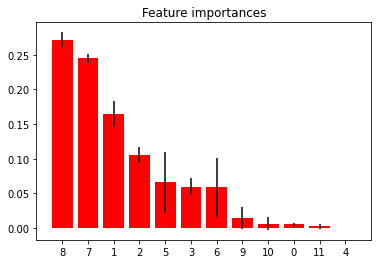

In [37]:
importances  = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort( importances )[::-1]


# imprimindo o ranking das features
print("Feature Ranking:")
df = pd.DataFrame()

for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat( [df,aux], axis=0 )

    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. MODELO DE MACHINE LEARNING 

In [38]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]

x_train =  df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1. KNN

In [39]:
# Definição do Modelo
knn_model =  neighbors.KNeighborsClassifier( n_neighbors=7 )

# treinamento do modelo
knn_model.fit( x_train, y_train )

# Predição do modelo -> Medindo o poder de GENERALIZAÇÃO DO MODELO
yhat_knn =  knn_model.predict_proba( x_val ) 

<AxesSubplot:title={'center':'Lift CUrve Logistic Regressor'}, xlabel='Percentage of sample', ylabel='Lift'>

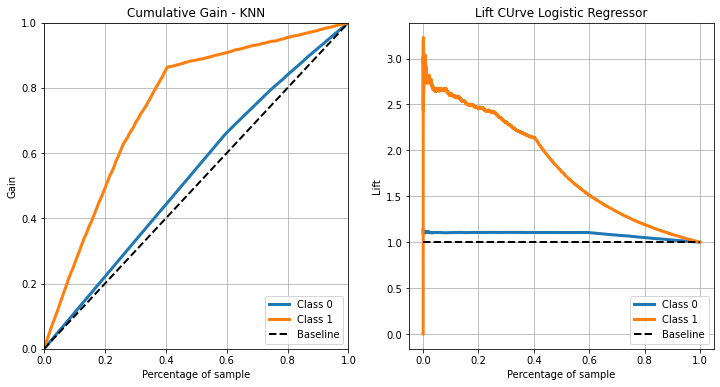

In [60]:
# Ganho Acumulado
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax=axs[0], title='Cumulative Gain - KNN' )
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axs[1], title='Lift CUrve Logistic Regressor')

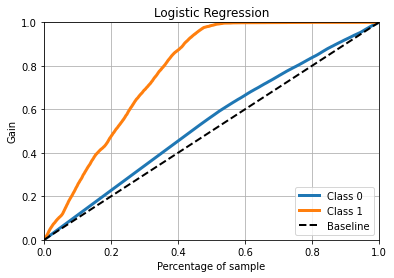

In [41]:
# Definição do Modelo
lr_model =  LogisticRegression( random_state=42 )

# treinamento do modelo
lr_model.fit( x_train, y_train )

# Predição do modelo -> Medindo o poder de GENERALIZAÇÃO DO MODELO
yhat_lr =  lr_model.predict_proba( x_val ) 

# Ganho Acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr )
plt.title('Logistic Regression');

## 8.0. Model Performance

In [42]:
def precision_at_k( data, k=2000):
    # reset index
    data = data.reset_index( drop=True ) 

    # criando ranking ordenado
    data['ranking'] = data.index + 1

    # Precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [43]:
def recall_at_k( data, k=2000):
    # reset index
    data = data.reset_index( drop=True ) 

    # criando ranking ordenado
    data['ranking'] = data.index + 1

    # Precision at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']


In [44]:
# copy data
df8 =  x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['propensity_score'] = yhat_knn[:,1].tolist()

# ordenando clientes pelo score de propensão
df8 = df8.sort_values('propensity_score', ascending=False)

# Calculando a precisao até k
# Predicoes Corretas até K /  Total de predicoes realizadas
precision_at_50 = precision_at_k(df8, k=50)
print( f'Precisão até K: {precision_at_50}' )

# Calculando recall até k -> predicoes corretas até k / todos eemplos verdadeiros
recall_at_50 = recall_at_k(df8, k=50)
print( f'Recall até K: {recall_at_50}' )

Precisão até K: 0.29411764705882354
Recall até K: 0.0016345210853220007


In [45]:
# reset index
df8 = df8.reset_index( drop=True ) 

# criando ranking ordenado
df8['ranking'] = df8.index + 1

# Precision at k
df8['precision_at_k'] = df8['response'].cumsum() / df8['ranking']

# df8
df8[['id', 'response', 'propensity_score', 'ranking', 'precision_at_k']].reset_index( drop=True ).head()

,id,response,propensity_score,ranking,precision_at_k
0,146128,0,1.0,1,0.0
1,264895,0,1.0,2,0.0
2,320340,0,1.0,3,0.0
3,37211,0,1.0,4,0.0
4,78968,1,1.0,5,0.2


In [46]:
dt = DecisionTreeClassifier( max_depth=3,splitter="best")

dt.fit(x_train, y_train)

yhat_dt = dt.predict_proba(x_val)

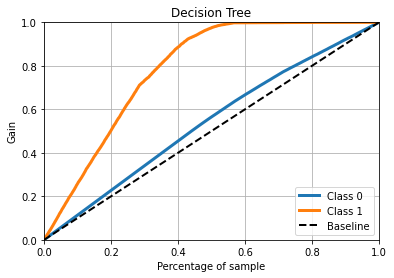

In [47]:
# Ganho Acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_dt )
plt.title('Decision Tree');

In [48]:
# # ExtraTree

# # Definição do Modelo
# et = ensemble.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state = 42)

# # Treinamento do Modelo 
# et.fit( x_train, y_train)

# # Precição do Modelo
# yhat_etet.predict_proba( x_val )

# # Ganho Acumulado
# skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )


# 8.0. HYPERPARAMETER FINETUNING

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO MODELO

# 10.0. DEPLOY DO MODELO

In [50]:
class HealthInsurance:
    def __init__( self ):
        self.home_path='C:/Users/ander/repos/Health_Insurance_Cross_Sell'
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl'))
        self.age_scaler = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl' ) ) 
        self.vintage_scaler = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl' ) )
        
        
    def data_cleaning( df1 ):
        df1.region_code = df1.region_code.astype( "int64")
        df1.annual_premium = df1.annual_premium.astype( "int64")
        df1.policy_sales_channel = df1.policy_sales_channel.astype( "int64")
        
        return df1

    def feature_engineering( df2 ):
        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'below_1_year' 
                                                      if x == '< 1 Year' else 'between_1_2_years' )
        # vehicle demage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        return df2
    
    def data_preparation( df3 ):
        # annual_premium -> bem parecido com uma normal
        df5['annual_premium']  = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age -> Não é muito próxima de uma normal 
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage -> Só vou reescalar, não aparenta ser útil
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender -  One Hot Encoding /  Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # region_code - Frequency Encoding, ou Target Encoding, ou Weighted Target Encoding
        
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / ORDER ENCODING / Frequence Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel - Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )

    
        # 6.0. SELEÇÃO DE ATRIBUTOS
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]
        
        return df5[cols_selected]
    
        def get_prediction( self, model, original_data, test_data ): 
            # predicao do modelo
            pred = model.predict_proba( test_data )
            
            # juntando a predicao com o modelo real
            original_data['prediction'] = pred
            
            return original_data.to_json( orient='records', date_format='iso')